#IMPORTS

In [ ]:
!pip install keras-tuner
!pip install tensorflow==2.14.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.0
    Uninstalling google-auth-oauthlib-1.2.0:
      Successfully uninstalled google-auth-oauthlib-1.2.0
  Attempting uninstall: t

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import librosa
import numpy as np
import json
import math
import os
import keras_tuner
import pickle
from keras.layers import (Masking,
                          Reshape,
                          RepeatVector,
                          Input,
                          InputLayer,
                          Dense,
                          Conv2D,
                          LSTM,
                          BatchNormalization,
                          ReLU,
                          MaxPooling2D,
                          GlobalMaxPool1D,
                          GlobalMaxPool2D,
                          TimeDistributed,
                          TextVectorization,
                          Embedding, Concatenate, Flatten, Dropout)

from keras.utils import to_categorical, plot_model,pad_sequences

from sklearn.model_selection import train_test_split

from nltk.translate.bleu_score import corpus_bleu

from keras.preprocessing.text import Tokenizer

In [ ]:
tf.__version__

'2.14.0'

In [ ]:
DS_PATH = "/content/drive/MyDrive/Colab Notebooks/fixed_caption_melspectrogram.pkl"

df = pd.read_pickle(DS_PATH)
df = df[['ytid','caption','mel_spectrogram']]
df.head()

,ytid,caption,mel_spectrogram
0,-0Gj8-vB1q4,The low quality recording features a ballad so...,"[[-14.097406, -11.082294, -8.232725, -10.62423..."
1,-0SdAVK79lg,This song features an electric guitar as the m...,"[[-2.7312694, -1.5929137, -2.828573, -2.417910..."
2,-0vPFx-wRRI,a male voice is singing a melody with changing...,"[[-12.465161, -14.239837, -10.702349, -10.1056..."
3,-0xzrMun0Rs,This song contains digital drums playing a sim...,"[[-3.4610844, -5.621482, -4.4565024, -4.377099..."
4,-1LrH01Ei1w,This song features a rubber instrument being p...,"[[11.892473, 11.391735, 10.117396, 9.940582, 1..."


In [ ]:
int(df['caption'].apply(lambda caption : len(caption.split())).max())

136

In [ ]:
df['caption'].apply(lambda caption : len(caption.split())).mean()

48.94481879439082

In [ ]:
len(df[df['caption'].apply(lambda caption : len(caption.split())) >= 50])

2322

In [ ]:
len(df[df['caption'].apply(lambda caption : "low quality" in caption)])

1248

In [ ]:
len(df[df['caption'].apply(lambda caption : "shimmering hi hats" in caption)])

196


#preprocessing and cleaning

In [ ]:
def get_max_sentence(caption,max_length):
    words = caption.split()[:max_length]
    if not '.' in words[max_length-1]:
        for i in range(len(words)-1,-1,-1):
            if '.' in words[i]:
                words = words[:i+1]
                break
    return " ".join(words)

def clean_captions(caption_sentences,max_length,add_token=True):
    # get max length with 2 training tokens
    if add_token:
      max_length = max_length-2

    if len(caption_sentences.split()) > max_length:
        caption_sentences = get_max_sentence(caption_sentences,max_length)
    # convert to lowercase
    captions = caption_sentences.lower()
    # delete digits, special chars, etc.,
    captions = caption_sentences.replace('[^A-Za-z]', '')
    # delete additional spaces
    captions = caption_sentences.replace('\s+', ' ')
    if add_token:
    # add start and end tags to the caption
      captions = 'startseq ' + captions + ' endseq'

    return captions


def reshape_mel(mel_spec):
    mel_spec = np.pad(mel_spec,[(0,0),(0,313-mel_spec.shape[1])],mode="constant",constant_values=0)
    return np.reshape(mel_spec,(mel_spec.shape[0],mel_spec.shape[1],1))

# MODELS

In [ ]:
word_embedding_dim = 300
encoder_hidden_dim = 256
decoder_hidden_dim = 256

## Encoders

In [ ]:
def build_audio_encoder(hp : keras_tuner.HyperParameters,input_layer,encoder_hidden_dim):

    audio_encoder = tf.keras.Sequential(name="audio_encoder")
    audio_encoder.add(input_layer)
    for depth in range(hp.Int(name="acnn_depth",min_value=1,max_value=3)):
        audio_encoder.add(Conv2D(filters=hp.Choice("filter_numbers",[32,64]),
                                                kernel_size=(3,3)))
        audio_encoder.add(BatchNormalization())
        audio_encoder.add(ReLU())

        hp_pooling_size_x = hp.Choice('pooling_size', values=[2, 3])
        audio_encoder.add(MaxPooling2D(pool_size=(hp_pooling_size_x,3),padding="same"))

    # audio encoder dense
    audio_encoder.add(Flatten())
    audio_encoder.add(Dense(encoder_hidden_dim))
    audio_encoder.add(BatchNormalization())
    audio_encoder.add(ReLU())

    return audio_encoder

def build_text_encoder(input_layer,word_embedding_dim):
    caption_embedding = tf.keras.Sequential(name="text_encoder")
    caption_embedding.add(input_layer)
    caption_embedding.add(Embedding(input_dim=vocab_size,
                                    output_dim=word_embedding_dim,
                                    weights=[embedding_matrix],
                                    name="caption_embedding"))

    return caption_embedding

## Decoder

In [ ]:
class DecoderModel(tf.keras.Model):
  def __init__(self,hidden_dim,vocab_size,dropout_rate,input_shape,h,c):
    super(DecoderModel, self).__init__()
    self.dropout_rate = dropout_rate
    self.h = tf.convert_to_tensor(h)
    self.c = tf.convert_to_tensor(c)
    self.input_layer = InputLayer(input_shape=(max_length,input_shape))
    self.LSTM = LSTM(units=hidden_dim,name="decoder_lstm",return_sequences=True,return_state=True)
    self.LSTM.initial_state = [h,c]
    self.dropout = Dropout(dropout_rate)
    self.dense = Dense(vocab_size,activation="softmax",name="output_dense")

  def call(self, inputs):
    x = self.input_layer(inputs)
    x,_,_ = self.LSTM(x)
    x = self.dropout(x)
    x = self.dense(x)
    return x

  def get_config(self):
    config = super(DecoderModel, self).get_config()
    config['hidden_dim'] = self.LSTM.units
    config['vocab_size'] = self.dense.units
    config['dropout_rate'] = self.dropout_rate
    config['input_shape'] = self.input_layer.input_shape[1:]  # Exclude batch size
    config['h'] = self.h.numpy()  # Convert to a numpy array
    config['c'] = self.c.numpy()  # Convert to a numpy array
    return config

In [ ]:
def create_decoder(hidden_dim,vocab_size,dropout_rate,input_shape,h,c):
  h = tf.convert_to_tensor(h)
  c = tf.convert_to_tensor(c)

  input_layer = Input(shape=(max_length,input_shape))

  lstm_layer = LSTM(units=hidden_dim,name="decoder_lstm",return_sequences=True)
  lstm_layer.initial_state = [h,c]

  dropout_layer = Dropout(dropout_rate)
  dense_layer = Dense(vocab_size,activation="softmax",name="output_dense")

  model = tf.keras.Sequential(name="decoder_model")
  model.add(input_layer)
  model.add(lstm_layer)
  model.add(dropout_layer)
  model.add(dense_layer)

  return model

##build method

In [ ]:
def build_model(hp : keras_tuner.HyperParameters,modality_fusion):
    global max_length

    dropout_rate = hp.Float(name="decoder_dropout_rt",min_value=0.25,max_value=0.4,step=0.1)

    audio_encoder_input = Input(shape=(128,313,1))
    text_encoder_input = Input(max_length)

    audio_encoder = build_audio_encoder(hp,audio_encoder_input,encoder_hidden_dim)
    text_encoder = build_text_encoder(text_encoder_input,word_embedding_dim)

    if modality_fusion == "early":
        encoder_lstm = LSTM(units=encoder_hidden_dim,
                            return_sequences=True,
                            return_state=True)
        audio_encoder_output = RepeatVector(text_encoder.output_shape[1])(audio_encoder.output)
        concat_layer = Concatenate(name="early_concatenate")([audio_encoder_output,text_encoder.output])
        fusion_output,h,c = encoder_lstm(concat_layer)
        print(f"early_fusion_output : {fusion_output}")


    if modality_fusion == "late":
        encoder_lstm = LSTM(units=encoder_hidden_dim,
                input_shape=(None, word_embedding_dim),
                return_sequences=True,
                return_state=True)
        fusion_output, h, c = encoder_lstm(text_encoder.output)
        audio_encoder_output = RepeatVector(text_encoder.output_shape[1])(audio_encoder.output)
        fusion_output = Concatenate(name="late_concatenate")([audio_encoder_output,fusion_output])
        print(f"late_fusion_output : {fusion_output}")

    if modality_fusion == "hybrid":
        audio_encoder_output = RepeatVector(text_encoder.output_shape[1])(audio_encoder.output)

        encoder_lstm_early = LSTM(units=encoder_hidden_dim,
                                  return_sequences=True,
                                  return_state=True,
                                  name="encoder_lstm_early")
        early_concat_layer = Concatenate(name="early_concatenate")([audio_encoder_output,text_encoder.output])
        early_fusion_output, h_early, c_early = encoder_lstm_early(early_concat_layer)
        encoder_lstm_late = LSTM(units=encoder_hidden_dim,
                                input_shape=(None, word_embedding_dim),
                                return_sequences=True,
                                return_state=True,
                                name="encoder_lstm_late")

        late_fusion_output, h_late, c_late = encoder_lstm_late(text_encoder.output)
        late_fusion_output = Concatenate(name="late_concatenate")([audio_encoder_output, late_fusion_output])
        fusion_output = Concatenate(name="hybrid_concatenate")([early_fusion_output, late_fusion_output])
        print(f"hybrid fusion_output : {fusion_output}")



    decoder_input_shape = encoder_hidden_dim if modality_fusion == "early" else encoder_hidden_dim*2 if modality_fusion == "late" else encoder_hidden_dim*3



    decoder_model = create_decoder(decoder_hidden_dim,
                                 vocab_size,
                                 dropout_rate,
                                 decoder_input_shape,
                                 audio_encoder.output,
                                 audio_encoder.output)

    decoder_output = decoder_model(fusion_output)

    model = tf.keras.Model(inputs=[audio_encoder.input,text_encoder.input],outputs=decoder_output,name="complete_model")

    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.Accuracy()]
                 )

    return model

# Data Generator

In [ ]:
class Data_Generator(tf.keras.utils.Sequence):
    def __init__(self, datasets, batch_size, max_length, vocab_size):
        self.datasets = datasets
        self.batch_size = batch_size
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.indexes = np.arange(len(self.datasets))


    def __len__(self):
        return int(np.ceil(len(self.datasets) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.datasets.iloc[batch_indexes]
        [x1, x2], y = self.__data_generation(batch_data)
        return [x1, x2], y


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        np.random.shuffle(self.indexes)

    def __data_generation(self, batch_data):
        x1, x2, y = [], [], []

        for index, row in batch_data.iterrows():
            caption = row['caption']
            seq = tokenizer.texts_to_sequences(["startseq " + caption + " endseq"])[0]
            seq_in = pad_sequences([seq[:-1]], maxlen=self.max_length,padding="post",truncating="post")[0]
            seq_out = to_categorical([
                pad_sequences([seq[1:]], maxlen=self.max_length,padding="post",truncating="post")[0]
            ], num_classes=self.vocab_size)[0]

            x1.append(row['mel_spectrogram'])
            x2.append(seq_in)
            y.append(seq_out)

        return [np.array(x1), np.array(x2)], np.array(y)

#Scripts

##prep

In [ ]:
#data-cleaning
df['mel_spectrogram'] = df['mel_spectrogram'].apply(reshape_mel)
df['caption'] = df['caption'].apply(lambda x : clean_captions(x,50,False))
raw_captions = df['caption'].apply(lambda x : clean_captions(x,52,True))

#get the longest caption +1 for <SOS> OR <EOS> token
max_length = int(df['caption'].apply(lambda caption : len(caption.split())).max())+1

print(f"max_length : {max_length}")
print(f"mel-shape : {df.loc[0]['mel_spectrogram'].shape}")
df.iloc[-2]['caption']

max_length : 51
mel-shape : (128, 313, 1)


'The song is an instrumental. The song is slow tempo with a steady drumming rhythm, triangle percussions, piano accompaniment, String synth harmony and strong bass line. The song is emotional and deeply meditative.'

In [ ]:
raw_captions.apply(lambda caption : len(caption.split())).max()

52

In [ ]:
tokenizer = Tokenizer(char_level=False,oov_token="<UNK>")
tokenizer.fit_on_texts(raw_captions)
vocab_size = len(tokenizer.word_index)+1
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 4899 unique tokens.


In [ ]:
embeddings_index = {}
f = open("/content/drive/MyDrive/Colab Notebooks/glove.6B.300d.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [ ]:
embedding_matrix = np.zeros((vocab_size, word_embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
X_train, X_test = train_test_split(df, test_size=0.1, random_state=20)
X_train, X_val = train_test_split(X_train, test_size=0.22, random_state=20)


print(f"train shape :  {X_train.shape}")
print(f"val shape : {X_val.shape}")
print(f"test shape : {X_test.shape}")

train shape :  (3853, 3)
val shape : (1088, 3)
test shape : (550, 3)


##tuning

In [ ]:
df_tune = X_val.iloc[:600]
X_tune,X_tune_val = train_test_split(df_tune, test_size=0.2, random_state=20)

tunegenerator = Data_Generator(X_tune,20,max_length,vocab_size)
tunevalgenerator = Data_Generator(X_tune_val,20,max_length,vocab_size)

In [ ]:
tuner_early = keras_tuner.RandomSearch(
    lambda hp : build_model(hp,"early"),
    objective=keras_tuner.Objective("val_loss",direction="min"),
    max_trials=10,
    directory='tuning',
    max_consecutive_failed_trials=5,
    project_name='music_captioning_early',
    overwrite=True,
)

early_fusion_output : KerasTensor(type_spec=TensorSpec(shape=(None, 51, 256), dtype=tf.float32, name=None), name='lstm_1/PartitionedCall:1', description="created by layer 'lstm_1'")


In [ ]:
tuner_late = keras_tuner.RandomSearch(
    lambda hp : build_model(hp,"late"),
    objective=keras_tuner.Objective("val_loss",direction="min"),
    max_trials=10,
    directory='tuning',
    max_consecutive_failed_trials=5,
    project_name='music_captioning_late',
    overwrite=True,
)

late_fusion_output : KerasTensor(type_spec=TensorSpec(shape=(None, 51, 512), dtype=tf.float32, name=None), name='late_concatenate/concat:0', description="created by layer 'late_concatenate'")


In [ ]:
tuner_hybrid = keras_tuner.RandomSearch(
    lambda hp : build_model(hp,"hybrid"),
    objective=keras_tuner.Objective("val_loss",direction="min"),
    max_trials=10,
    directory='tuning',
    max_consecutive_failed_trials=5,
    project_name='music_captioning_hybrid',
    overwrite=True,
)

hybrid fusion_output : KerasTensor(type_spec=TensorSpec(shape=(None, 51, 768), dtype=tf.float32, name=None), name='hybrid_concatenate/concat:0', description="created by layer 'hybrid_concatenate'")


In [ ]:
tuner_early.search(tunegenerator,
             validation_data=tunevalgenerator,
             epochs=15,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Trial 10 Complete [00h 00m 17s]
val_loss: 4.995840072631836

Best val_loss So Far: 4.5087127685546875
Total elapsed time: 00h 05m 43s


In [ ]:
tuner_late.search(tunegenerator,
             validation_data=tunevalgenerator,
             epochs=15,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Trial 10 Complete [00h 00m 34s]
val_loss: 4.426825046539307

Best val_loss So Far: 4.344775199890137
Total elapsed time: 00h 05m 49s


In [ ]:
tuner_hybrid.search(tunegenerator,
             validation_data=tunevalgenerator,
             epochs=15,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Trial 10 Complete [00h 00m 57s]
val_loss: 4.540543079376221

Best val_loss So Far: 4.403078556060791
Total elapsed time: 00h 07m 46s


In [ ]:
plot_model(tuner_early.get_best_models()[0],show_shapes=True,show_layer_names=True)

In [ ]:
plot_model(tuner_late.get_best_models()[0],show_shapes=True,show_layer_names=True)

In [ ]:
plot_model(tuner_hybrid.get_best_models()[0],show_shapes=True,show_layer_names=True)

In [ ]:
best_early_fusion = tuner_early.get_best_models()[0]
best_late_fusion = tuner_late.get_best_models()[0]
best_hybrid_fusion = tuner_hybrid.get_best_models()[0]

early_fusion_output : KerasTensor(type_spec=TensorSpec(shape=(None, 51, 256), dtype=tf.float32, name=None), name='lstm/PartitionedCall:1', description="created by layer 'lstm'")
late_fusion_output : KerasTensor(type_spec=TensorSpec(shape=(None, 51, 512), dtype=tf.float32, name=None), name='late_concatenate/concat:0', description="created by layer 'late_concatenate'")
hybrid fusion_output : KerasTensor(type_spec=TensorSpec(shape=(None, 51, 768), dtype=tf.float32, name=None), name='hybrid_concatenate/concat:0', description="created by layer 'hybrid_concatenate'")


In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/best_model_late.json","w") as late_json:
  late_json.write(best_late_fusion.to_json())

with open("/content/drive/MyDrive/Colab Notebooks/best_model_early.json","w") as early_json:
  early_json.write(best_early_fusion.to_json())

with open("/content/drive/MyDrive/Colab Notebooks/best_model_hybrid.json","w") as hybrid_json:
  hybrid_json.write(best_hybrid_fusion.to_json())

In [ ]:
best_early_fusion.save("/content/drive/MyDrive/Colab Notebooks/keras_model/best_early_model.keras")
best_late_fusion.save("/content/drive/MyDrive/Colab Notebooks/keras_model/best_late_model.keras")
best_hybrid_fusion.save("/content/drive/MyDrive/Colab Notebooks/keras_model/best_hybrid_model.keras")

In [ ]:
best_hps = tuner.get_best_hyperparameters()

In [ ]:
best_hps[0].values

{'modality fusion': 'late',
 'decoder_dropout_rt': 0.35,
 'acnn_depth': 2,
 'filter_numbers': 32,
 'pooling_size': 3}

In [ ]:
tuner_late.search_space_summary()

Search space summary
Default search space size: 4
decoder_dropout_rt (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.25, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
acnn_depth (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
filter_numbers (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
pooling_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}


In [ ]:
best_models[3].get_layer('decoder_model').get_layer('dropout').rate

0.35

##training

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=2)

In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/best_model_early.json","r") as early_json:
  early_model_json = early_json.read()
  best_early_fusion = tf.keras.models.model_from_json(early_model_json)
with open("/content/drive/MyDrive/Colab Notebooks/best_model_late.json","r") as late_json:
  late_model_json = late_json.read()
  best_late_fusion = tf.keras.models.model_from_json(late_model_json)
with open("/content/drive/MyDrive/Colab Notebooks/best_model_hybrid.json","r") as hybrid_json:
  hybrid_model_json = hybrid_json.read()
  best_hybrid_fusion = tf.keras.models.model_from_json(hybrid_model_json)

In [ ]:
train_generator = Data_Generator(X_train,15,max_length,vocab_size)
val_generator = Data_Generator(X_val,15,max_length,vocab_size)

In [ ]:
best_early_fusion.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.Accuracy()]
                 )
best_early_fusion.fit(train_generator,
               validation_data=val_generator,
               epochs=50,
               callbacks=[early_stop])


best_early_fusion.save("/content/drive/MyDrive/Colab Notebooks/keras_model/best_early_model_trained.keras")
with open("/content/drive/MyDrive/Colab Notebooks/history_model_early","wb") as early_history:
  pickle.dump(best_early_fusion.history.history,early_history)
  best_early_fusion.save_weights("/content/drive/MyDrive/Colab Notebooks/weights_early.h5")


Epoch 1/50
257/257 [==============================] - 36s 80ms/step - loss: 4.9676 - accuracy: 0.0000e+00 - val_loss: 4.4512 - val_accuracy: 0.0000e+00
Epoch 2/50
257/257 [==============================] - 10s 37ms/step - loss: 4.3454 - accuracy: 0.0000e+00 - val_loss: 4.2355 - val_accuracy: 0.0000e+00
Epoch 3/50
257/257 [==============================] - 10s 40ms/step - loss: 4.1114 - accuracy: 0.0000e+00 - val_loss: 3.9384 - val_accuracy: 0.0000e+00
Epoch 4/50
257/257 [==============================] - 9s 36ms/step - loss: 3.7970 - accuracy: 0.0000e+00 - val_loss: 3.6378 - val_accuracy: 0.0000e+00
Epoch 5/50
257/257 [==============================] - 9s 36ms/step - loss: 3.4935 - accuracy: 0.0000e+00 - val_loss: 3.3407 - val_accuracy: 0.0000e+00
Epoch 6/50
257/257 [==============================] - 9s 36ms/step - loss: 3.2083 - accuracy: 0.0000e+00 - val_loss: 3.0996 - val_accuracy: 0.0000e+00
Epoch 7/50
257/257 [==============================] - 9s 35ms/step - loss: 2.9899 - accurac

In [ ]:
best_late_fusion.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.Accuracy()]
                 )

best_late_fusion.fit(train_generator,
               validation_data=val_generator,
               epochs=50,
               callbacks=[early_stop])


best_late_fusion.save("/content/drive/MyDrive/Colab Notebooks/keras_model/best_late_model_trained.keras")
with open("/content/drive/MyDrive/Colab Notebooks/history_model_late","wb") as late_history:
  pickle.dump(best_late_fusion.history.history,late_history)
  best_late_fusion.save_weights("/content/drive/MyDrive/Colab Notebooks/weights_late.h5")

Epoch 1/50
257/257 [==============================] - 25s 75ms/step - loss: 4.8956 - accuracy: 0.0000e+00 - val_loss: 4.4380 - val_accuracy: 0.0000e+00
Epoch 2/50
257/257 [==============================] - 15s 56ms/step - loss: 4.3205 - accuracy: 0.0000e+00 - val_loss: 4.2183 - val_accuracy: 0.0000e+00
Epoch 3/50
257/257 [==============================] - 14s 53ms/step - loss: 4.1136 - accuracy: 0.0000e+00 - val_loss: 4.0007 - val_accuracy: 0.0000e+00
Epoch 4/50
257/257 [==============================] - 14s 53ms/step - loss: 3.8447 - accuracy: 0.0000e+00 - val_loss: 3.6581 - val_accuracy: 0.0000e+00
Epoch 5/50
257/257 [==============================] - 14s 54ms/step - loss: 3.4274 - accuracy: 0.0000e+00 - val_loss: 3.2461 - val_accuracy: 0.0000e+00
Epoch 6/50
257/257 [==============================] - 14s 54ms/step - loss: 3.0774 - accuracy: 0.0000e+00 - val_loss: 2.9746 - val_accuracy: 0.0000e+00
Epoch 7/50
257/257 [==============================] - 14s 53ms/step - loss: 2.8369 - acc

In [ ]:
best_hybrid_fusion.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.Accuracy()]
                 )

best_hybrid_fusion.fit(train_generator,
               validation_data=val_generator,
               epochs=50,
               callbacks=[early_stop])


best_hybrid_fusion.save("/content/drive/MyDrive/Colab Notebooks/keras_model/best_hybrid_model_trained.keras")
with open("/content/drive/MyDrive/Colab Notebooks/history_model_hybrid","wb") as hybrid_history:
  pickle.dump(best_hybrid_fusion.history.history,hybrid_history)
  best_hybrid_fusion.save_weights("/content/drive/MyDrive/Colab Notebooks/weights_hybrid.h5")

Epoch 1/50
257/257 [==============================] - 27s 77ms/step - loss: 4.8226 - accuracy: 0.0000e+00 - val_loss: 4.4035 - val_accuracy: 0.0000e+00
Epoch 2/50
257/257 [==============================] - 14s 54ms/step - loss: 4.2765 - accuracy: 0.0000e+00 - val_loss: 4.0875 - val_accuracy: 0.0000e+00
Epoch 3/50
257/257 [==============================] - 14s 54ms/step - loss: 3.7506 - accuracy: 0.0000e+00 - val_loss: 3.3874 - val_accuracy: 0.0000e+00
Epoch 4/50
257/257 [==============================] - 14s 53ms/step - loss: 3.1662 - accuracy: 0.0000e+00 - val_loss: 2.9764 - val_accuracy: 0.0000e+00
Epoch 5/50
257/257 [==============================] - 13s 52ms/step - loss: 2.8304 - accuracy: 0.0000e+00 - val_loss: 2.7461 - val_accuracy: 0.0000e+00
Epoch 6/50
257/257 [==============================] - 13s 52ms/step - loss: 2.6131 - accuracy: 0.0000e+00 - val_loss: 2.6064 - val_accuracy: 0.0000e+00
Epoch 7/50
257/257 [==============================] - 13s 52ms/step - loss: 2.4598 - acc

##evaluation


In [ ]:
# with open("/content/drive/MyDrive/Colab Notebooks/best_model_late.json","r") as late_json:
#   late_config = late_json.read()
# late_model = tf.keras.models.model_from_json(late_config)

# with open("/content/drive/MyDrive/Colab Notebooks/best_model_early.json","r") as early_json:
#   early_config = early_json.read()
# early_model = tf.keras.models.model_from_json(early_config)


# early_model.load_weights("/content/drive/MyDrive/Colab Notebooks/weights_early.h5")
# late_model.load_weights("/content/drive/MyDrive/Colab Notebooks/weights_late.h5")

In [ ]:
early_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/keras_model/best_early_model_trained.keras")
late_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/keras_model/best_late_model_trained.keras")
hybrid_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/keras_model/best_hybrid_model_trained.keras")

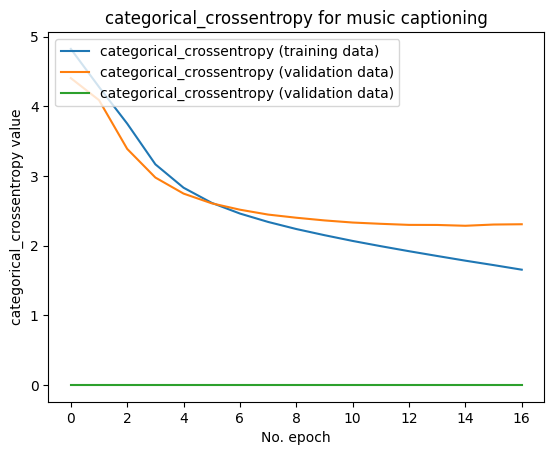

In [ ]:
def plot_history(model_name,acc = False):
  with open("/content/drive/MyDrive/Colab Notebooks/history_model_"+model_name,"rb") as history_file:
    history_file = pickle.load(history_file)
  # Plot history: categorical_crossentropy
  plt.plot(history_file['loss'], label='categorical_crossentropy (training data)')
  plt.plot(history_file['val_loss'], label='categorical_crossentropy (validation data)')
  if acc:
    plt.plot(history_file['accuracy'], label='categorical_crossentropy (validation data)')
  plt.title('categorical_crossentropy for music captioning')
  plt.ylabel('categorical_crossentropy value')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper left")
  plt.show()

plot_history("hybrid",True)

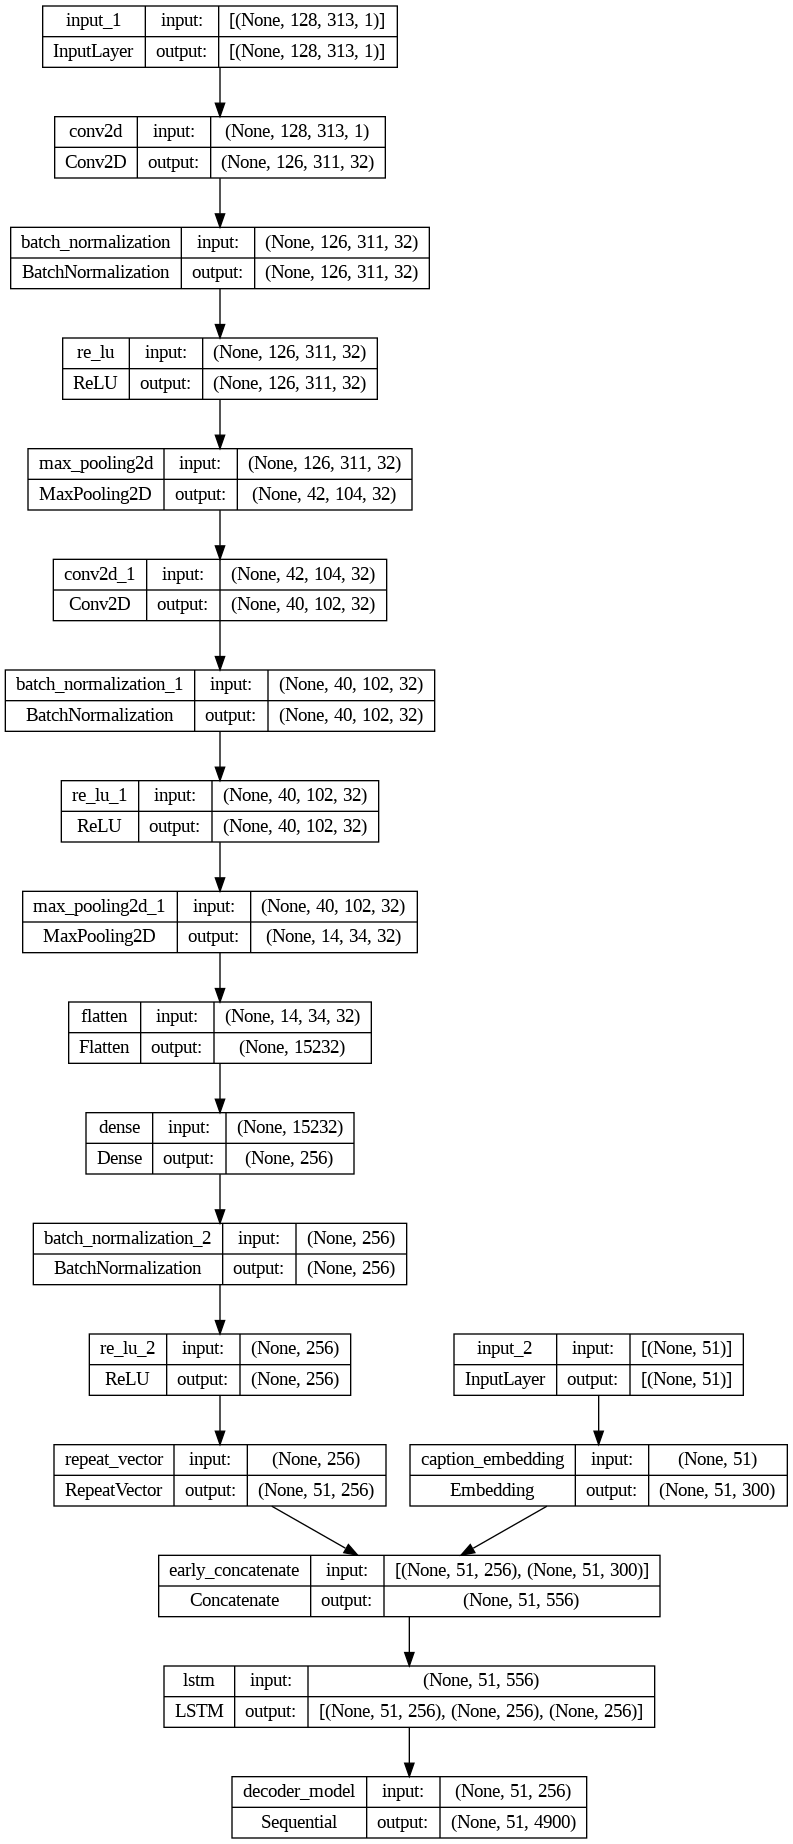

In [ ]:
plot_model(early_model,show_layer_names=True,show_shapes=True)

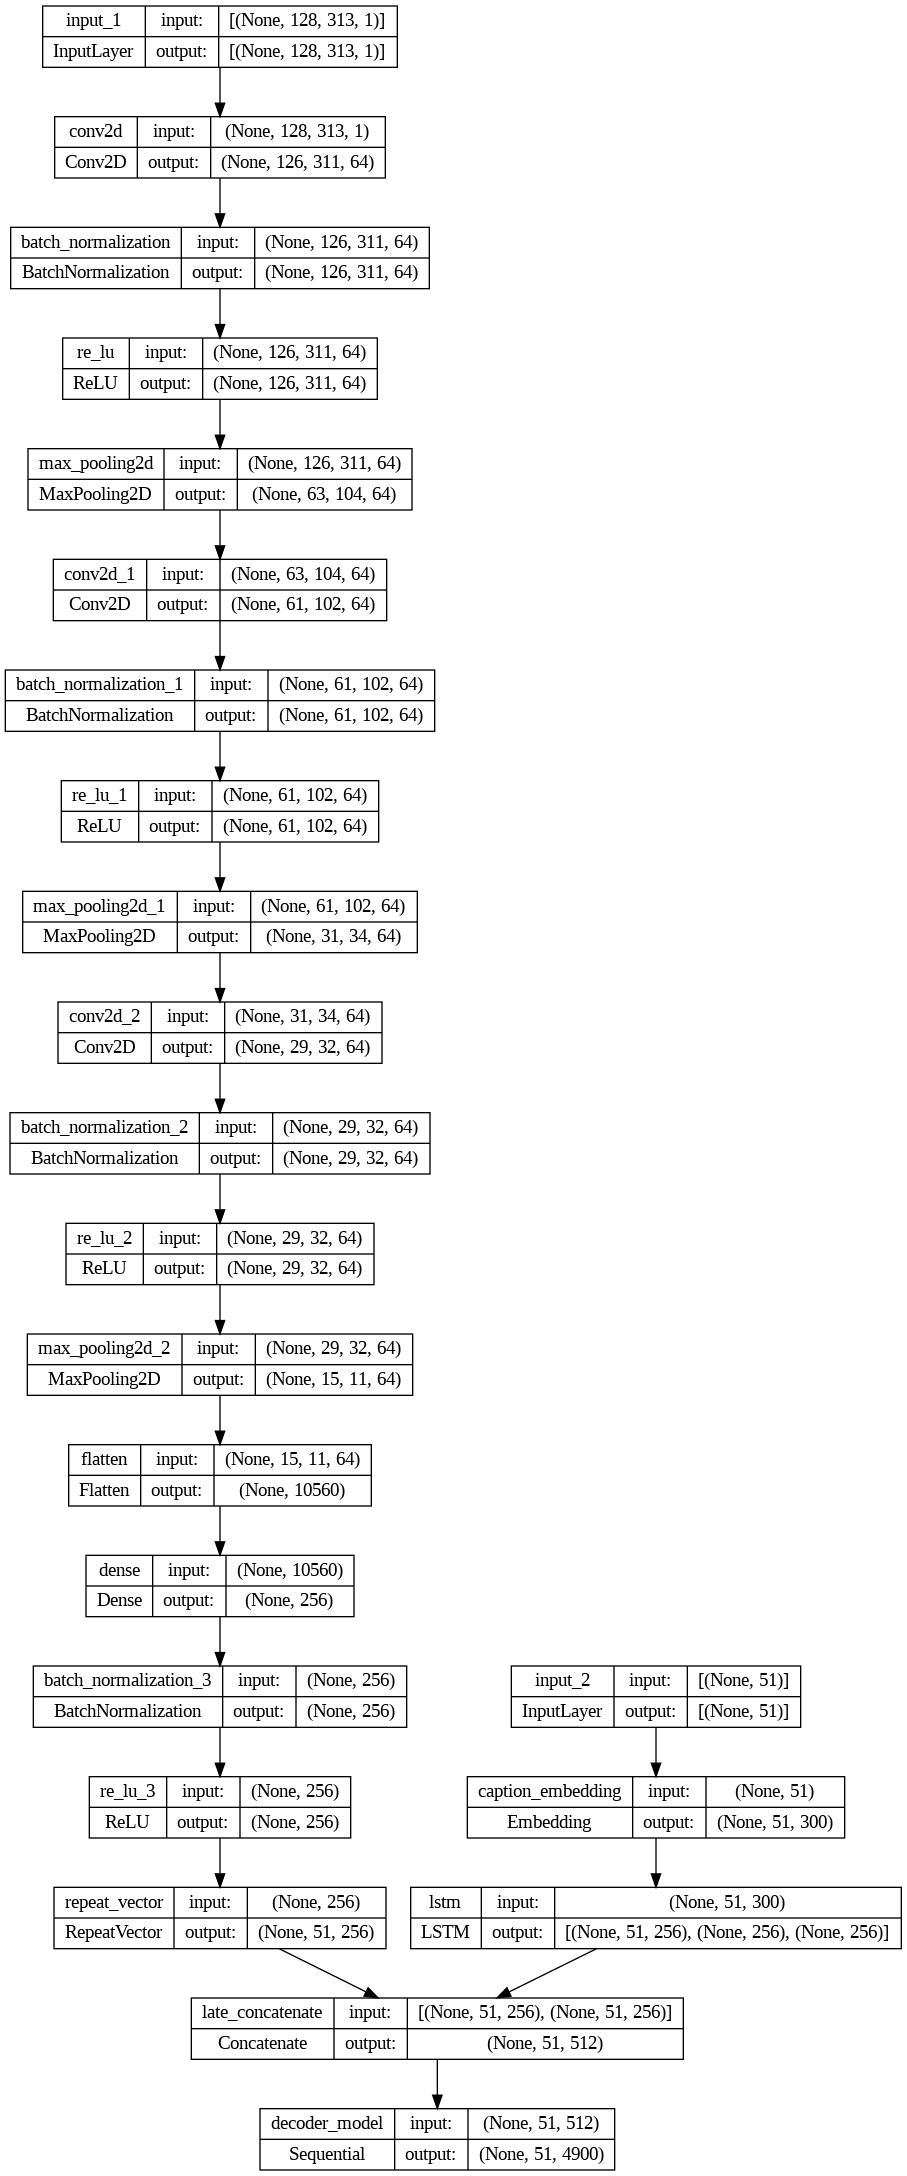

In [ ]:
plot_model(late_model,show_layer_names=True,show_shapes=True)

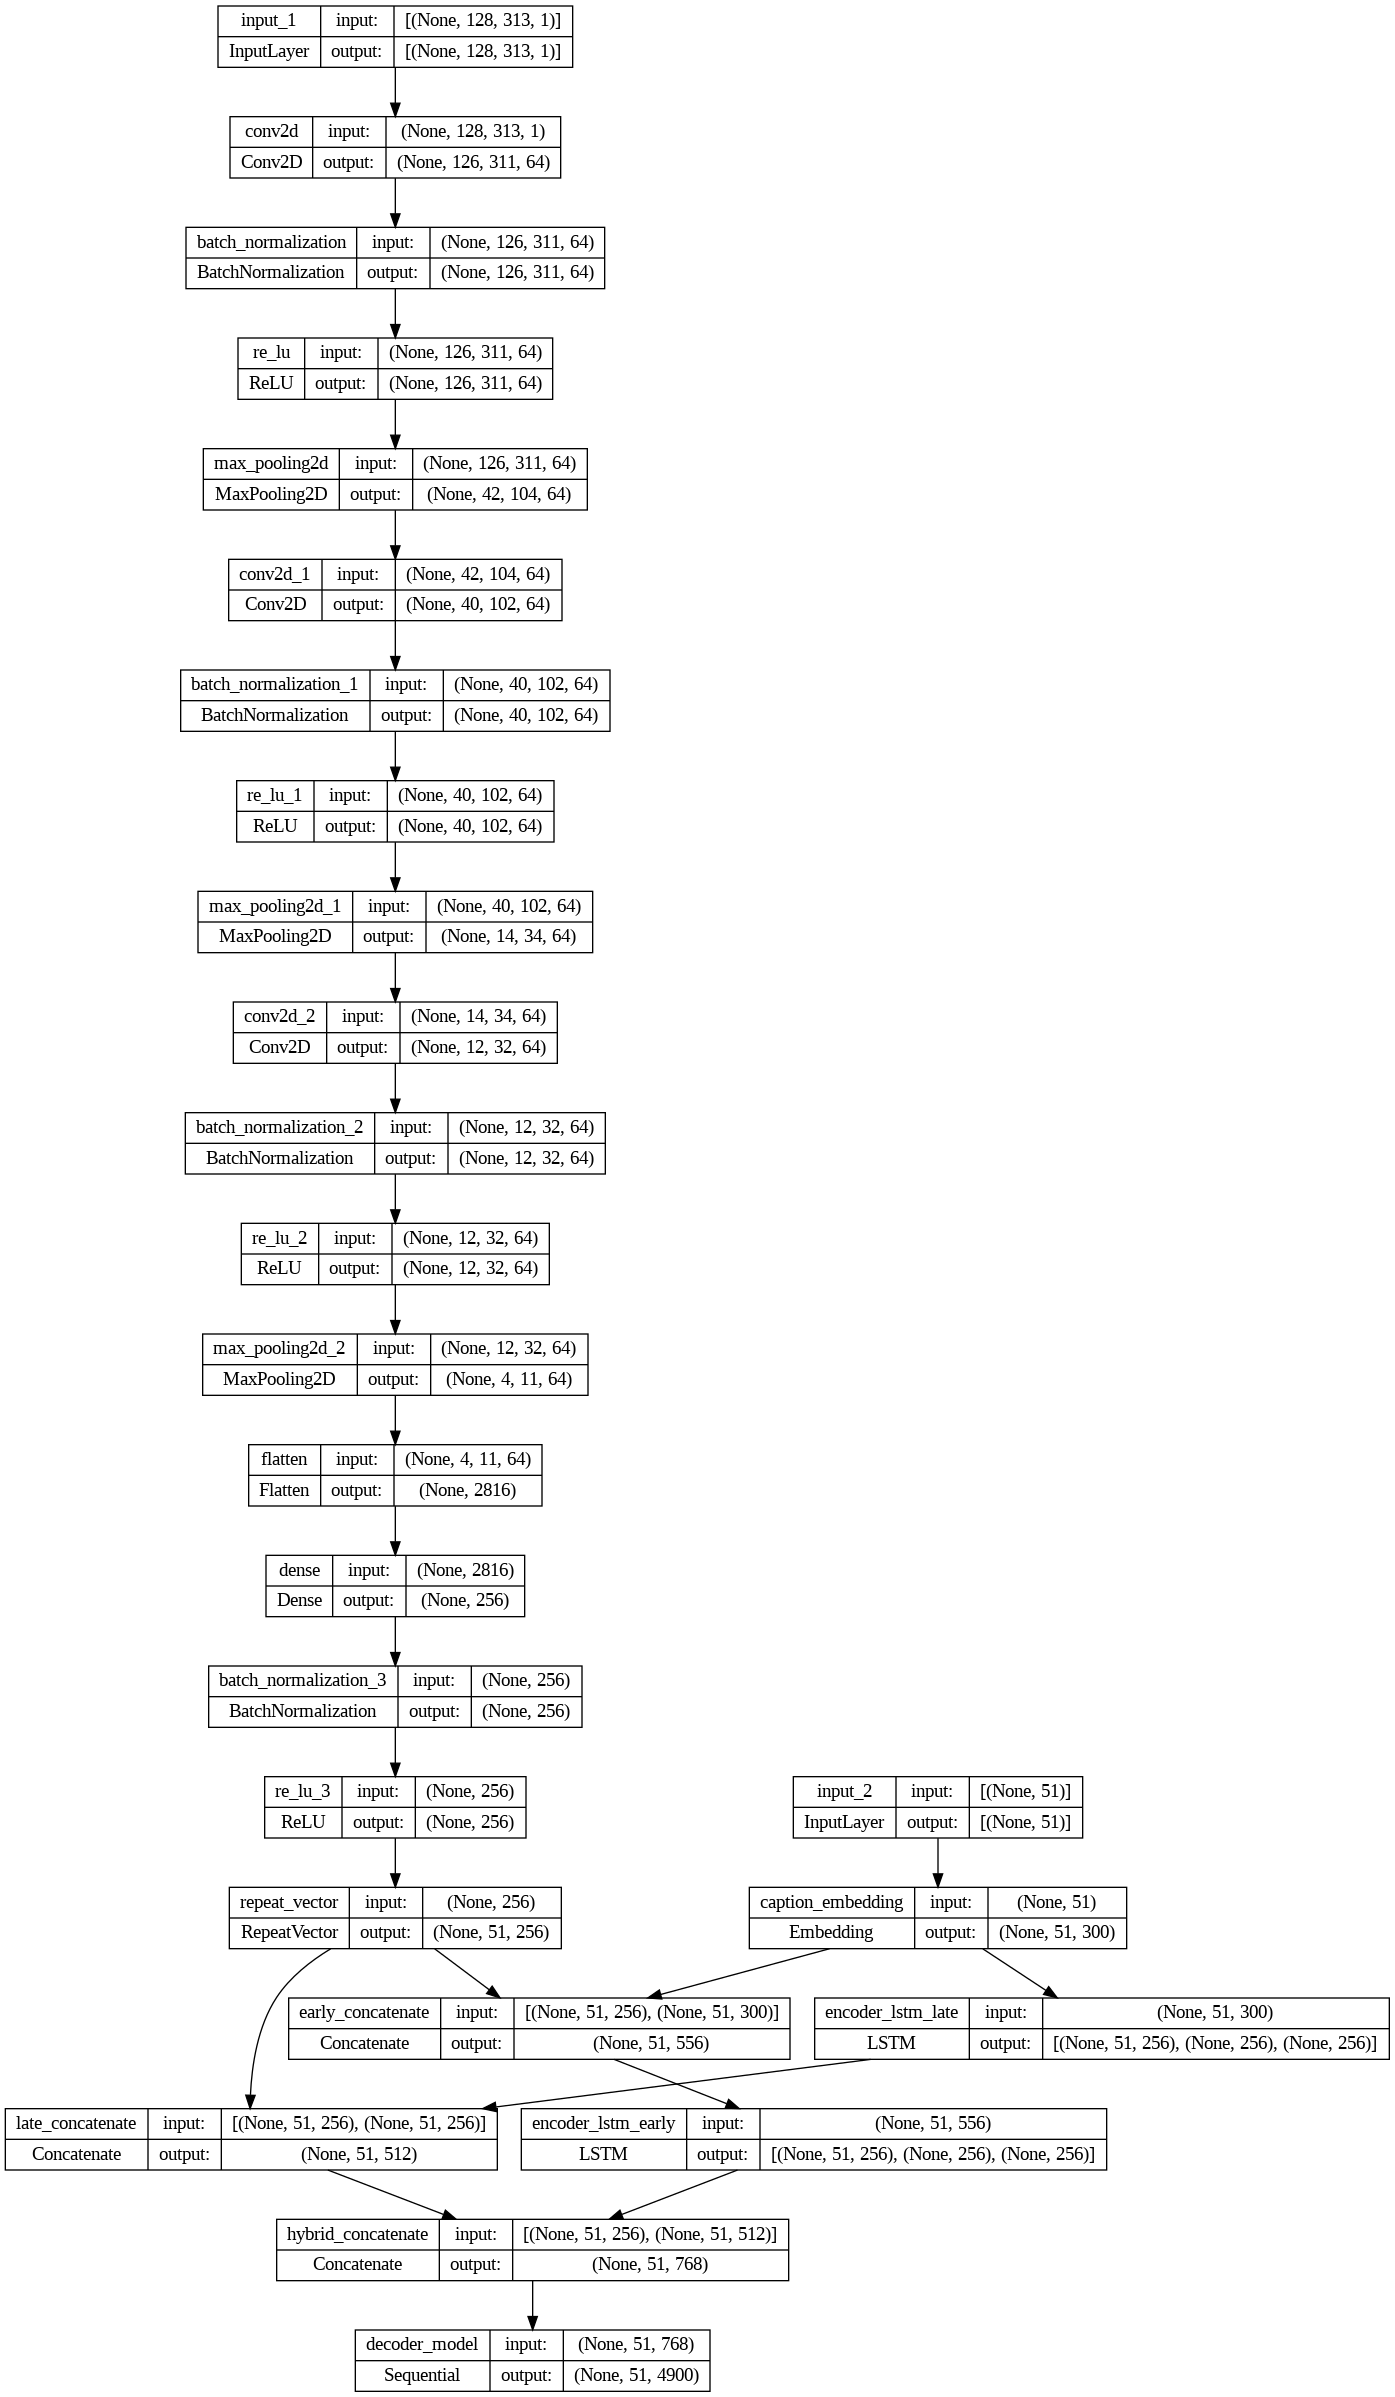

In [ ]:
plot_model(hybrid_model,show_layer_names=True,show_shapes=True)

In [ ]:
def beam_search(model,audio, start_token, end_token, max_sequence_length, beam_width):
    sequences = [[start_token, 0.0]]
    step = 0
    while step < max_sequence_length:
        all_candidates = []
        all_end_tokens = True
        for seq, score in sequences:
            if seq.split()[-1] == end_token:
                # If end token is reached, exclude this sequence from further consideration
                all_candidates.append([seq, score])
                continue

            input_sequence = pad_sequences([tokenizer.texts_to_sequences([seq])[0]], maxlen=max_length, padding='post')
            next_word_probabilities = model.predict([audio, input_sequence],verbose=0)[0]
            top_words = np.argsort(next_word_probabilities[step])[-beam_width:]
            for word in top_words:
                new_seq = seq +" "+tokenizer.sequences_to_texts([[word]])[0]
                new_score = score + np.log(next_word_probabilities[step][word])
                all_candidates.append([new_seq, new_score])

                if tokenizer.sequences_to_texts([[word]])[0] != end_token:
                  all_end_tokens = False

        if all_end_tokens :
            break
        step +=1
        sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]

    best_sequence = sequences[0][0].split()

    return best_sequence

def beam_search_decode(model : tf.keras.Model,audio,max_length,beam_width=5):
  start_token = 'startseq'
  end_token = 'endseq'
  result = beam_search(model,audio, start_token, end_token, max_length, beam_width)
  if result[-1] == end_token:
    result = " ".join(result[1:-1])
  else:
    result = " ".join(result[1:])
  return result

def greedy_decode(model : tf.keras.Model,audio,max_length):
  start_token = 'startseq'
  end_token = 'endseq'
  for step in range(max_length):
    seq = pad_sequences([tokenizer.texts_to_sequences([start_token])[0]], maxlen=max_length, padding='post')
    result = model.predict([audio,seq],verbose=False)[0]
    result = tokenizer.sequences_to_texts([[np.argmax(result[step])]])[0]
    start_token += " " + result
    if result == end_token:
      start_token = " ".join(start_token.split()[:-1])
      break


  return " ".join(start_token.split()[1:])

In [ ]:
from tqdm.notebook import tqdm

def predict_caption(model : tf.keras.Model, test_dataset : pd.DataFrame, beam_width=5):
  actual, predicted_beam, predicted_greedy, = list(), list() ,list()
  for index,test_data in tqdm(test_dataset.iterrows(), total=test_dataset.shape[0]):
    audio_data = np.expand_dims(test_data['mel_spectrogram'],0)
    output_beam = beam_search_decode(model,audio_data,max_length,beam_width)
    # output_greedy = greedy_decode(model,audio_data,max_length)
    # print(f"index : {index}, ytid : {index,test_data['ytid']}")
    # print("result_beam :",output_beam)
    # print("actual :",test_data['caption'])
    # print("-------------------------------------------------------------------")
    actual.append([test_data['caption']]) #add the actual caption
    predicted_beam.append(output_beam) #add the predicted caption beam
    # predicted_greedy.append(output_greedy) #add the predicted caption greedy

  return actual,predicted_beam,predicted_greedy

In [ ]:
pad_sequences([tokenizer.texts_to_sequences(['startseq'])[0]], maxlen=max_length, padding='post')

array([[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [ ]:
yhat =late_model.predict([
    np.expand_dims(X_test.iloc[0]['mel_spectrogram'],0),
    pad_sequences([tokenizer.texts_to_sequences(['startseq <UNK>'])[0]], maxlen=max_length, padding='post')
])[0]

1/1 [==============================] - 0s 90ms/step


In [ ]:
words = np.argsort(yhat[0])[-5:]

In [ ]:
tokenizer.sequences_to_texts([words])

['an someone a the this']

In [ ]:
yhat[0][words[2]]

0.020249695

In [ ]:
X_test.iloc[0]['caption']

'This audio contains someone playing a complex groove on tablas along with someone playing a solo on a zitar with the same complex rhythm. This song may be playing in a live concert having a little solo together with instruments.'

In [ ]:
beam_search_decode(early_model,np.expand_dims(X_test.iloc[0]['mel_spectrogram'],0),max_length)

'this is a live performance of a gospel music piece there is a male vocalist singing melodically in the lead the tune is being played by an electric guitar the atmosphere is dreamy'

In [ ]:
beam_search_decode(late_model,np.expand_dims(X_test.iloc[0]['mel_spectrogram'],0),max_length,beam_width=3)

'the low quality recording features a live performance of a traditional song and it consists of a passionate male vocal singing over acoustic rhythm guitar melody it sounds passionate emotional and passionate'

In [ ]:
beam_search_decode(hybrid_model,np.expand_dims(X_test.iloc[0]['mel_spectrogram'],0),max_length,beam_width=3)

'the low quality recording features a live performance of a classical song and it consists of a passionate male vocal singing over acoustic rhythm guitar it sounds emotional and passionate'

In [ ]:
X_test.iloc[60]['caption']

'The low quality recording features a groovy buzzy synth bass with a filter effect on it, followed by punchy "4 on the floor" kick pattern, shimmering hi hats, wide mellow high pitched sound effect and echoing male vocal singing over it. It sounds energetic and groovy.'

In [ ]:
beam_search_decode(early_model,np.expand_dims(X_test.iloc[60]['mel_spectrogram'],0),max_length)

'the song is an instrumental the song is medium tempo with a strong bass line steady drumming rhythm groovy bass line and a strong bass line the song is exciting and energetic'

In [ ]:
beam_search_decode(late_model,np.expand_dims(X_test.iloc[60]['mel_spectrogram'],0),max_length,beam_width=3)

'a male singer sings this cool melody with backup singers in vocal harmony the song is medium fast tempo with a groovy bass line steady drumming rhythm keyboard accompaniment and a groovy bass line the song is exciting and exciting the song is a retro pop song'

In [ ]:
beam_search_decode(hybrid_model,np.expand_dims(X_test.iloc[60]['mel_spectrogram'],0),max_length,beam_width=3)

'the song is an instrumental the song is medium tempo with a groovy bass line steady drumming rhythm and a strong bass line the song is exciting and energetic the song is a modern hip hop hit'

In [ ]:
X_test.iloc[100]['caption']

'The low quality recording features a repetitive didgeridoo melody. The recording is noisy and in mono, since it was probably recorded with a phone, and it sounds really low in frequency.'

In [ ]:
beam_search_decode(early_model,np.expand_dims(X_test.iloc[100]['mel_spectrogram'],0),max_length)

'the low quality recording features a live performance of a rock song that consists of a flat male vocal talking after which the recording is noisy and in mono'

In [ ]:
beam_search_decode(late_model,np.expand_dims(X_test.iloc[100]['mel_spectrogram'],0),max_length,beam_width=3)

'the low quality recording features a live performance of a rock song and it consists of a passionate male vocal singing over sustained strings melody and sustained strings melody it sounds passionate and passionate'

In [ ]:
beam_search_decode(hybrid_model,np.expand_dims(X_test.iloc[100]['mel_spectrogram'],0),max_length,beam_width=3)

'this music is instrumental the tempo is medium with an intense electric guitar harmony with no other instrumentation the audio quality is inferior and the sound of the music is scary and intense'

In [ ]:
X_test.iloc[8]['caption']

'The low quality, mono recording features a classical song performed by sad violin melody and harpsichord. The recording is noisy and it sounds emotional and passionate.'

In [ ]:
beam_search_decode(early_model,np.expand_dims(X_test.iloc[8]['mel_spectrogram'],0),max_length)

'the low quality recording features a live performance of a rock song and it consists of passionate male vocal singing over acoustic rhythm guitar melody the recording is noisy and in mono'

In [ ]:
beam_search_decode(late_model,np.expand_dims(X_test.iloc[8]['mel_spectrogram'],0),max_length,beam_width=3)

'the song is an instrumental the song is slow tempo with a piano accompaniment and no other instrumentation the song is emotional and emotional the song is a movie soundtrack'

In [ ]:
beam_search_decode(hybrid_model,np.expand_dims(X_test.iloc[8]['mel_spectrogram'],0),max_length,beam_width=3)

'the low quality recording features a live performance of a classical song and it consists of a passionate female vocal singing over acoustic guitar melody it sounds passionate and emotional'

###late_fusion evaluation

In [ ]:
actual_late, predicted_beam, predicted_greedy = predict_caption(late_model,X_test,beam_width=3)

  0%|          | 0/550 [00:00<?, ?it/s]

In [ ]:
# # calcuate BLEU score greedy
# print("GREEDY DECODING :")
# print("BLEU-1: %f" % corpus_bleu(actual_late, predicted_late_greedy, weights=(1.0, 0, 0, 0)))
# print("BLEU-2: %f" % corpus_bleu(actual_late, predicted_late_greedy, weights=(0.5, 0.5, 0, 0)))
# print("BLEU-4: %f" % corpus_bleu(actual_late, predicted_late_greedy))
# print("--------------------------------------------")
# calcuate BLEU score beam search
print("BEAM SEARCH DECODING :")
print("BLEU-1: %f" % corpus_bleu(actual_late, predicted_beam, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_late, predicted_beam, weights=(0.5, 0.5, 0, 0)))
print("BLEU-4: %f" % corpus_bleu(actual_late, predicted_beam))

BEAM SEARCH DECODING :
BLEU-1: 0.773198
BLEU-2: 0.617374
BLEU-4: 0.370171


In [ ]:
X_test.iloc[5]['caption']

'The song sounds epic and is fully orchestrated with a string section; brass section; a male choir in the background, fast timpani hits and strings playing a melody.'

In [ ]:
beam_search_decode(late_model,np.expand_dims(X_test.iloc[5]['mel_spectrogram'],0),max_length)

'this music is an electronic instrumental the tempo is medium with a groovy bass line keyboard harmony groovy bass line and keyboard accompaniment the music is youthful youthful energetic engaging and youthful'

In [ ]:
greedy_decode(late_model,np.expand_dims(X_test.iloc[5]['mel_spectrogram'],0),max_length)

'this is a live recording of a rock music piece there is a male vocalist singing melodically the main melody is being played by the electric guitar the bass guitar is playing a simple bass line the atmosphere is playful'

###early_fusion evaluation

In [ ]:
actual, predicted_beam, predicted_greedy = predict_caption(early_model,X_test)

# calcuate BLEU score beam search
print("BEAM SEARCH DECODING :")
print("BLEU-1: %f" % corpus_bleu(actual, predicted_beam, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted_beam, weights=(0.5, 0.5, 0, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted_beam))

  0%|          | 0/550 [00:00<?, ?it/s]

BEAM SEARCH DECODING :
BLEU-1: 0.722126
BLEU-2: 0.576129
BLEU-4: 0.341797


In [ ]:
# calcuate BLEU score greedy
print("GREEDY DECODING :")
print("BLEU-1: %f" % corpus_bleu(actual, predicted_greedy, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted_greedy, weights=(0.5, 0.5, 0, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted_greedy))
print("--------------------------------------------")
# calcuate BLEU score beam search
print("BEAM SEARCH DECODING :")
print("BLEU-1: %f" % corpus_bleu(actual, predicted_beam, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted_beam, weights=(0.5, 0.5, 0, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted_beam))

### hybrid_fusion_evaluation

In [ ]:
actual, predicted_beam, predicted_greedy = predict_caption(hybrid_model,X_test,beam_width=3)

print("BEAM SEARCH DECODING :")
print("BLEU-1: %f" % corpus_bleu(actual, predicted_beam, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted_beam, weights=(0.5, 0.5, 0, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted_beam))

  0%|          | 0/550 [00:00<?, ?it/s]

BEAM SEARCH DECODING :
BLEU-1: 0.719942
BLEU-2: 0.579592
BLEU-4: 0.351909


##inference

In [ ]:
HOP_LENGTH = 1024 #HOP_LENGTH FOR WINDOWING
FRAME_SIZE = 4096 #COMMON FRAME_SIZE 4XHOP_LENGTH
N_MELS = 128      #NUMBER OF MEL_BANDS
SR = 16000        #SAMPLING RATE

def assign_mel_spectrogram(signal) :
  mel_spec = librosa.feature.melspectrogram(y=signal,
                  sr=SR,
                  n_fft=FRAME_SIZE,
                  hop_length=HOP_LENGTH,
                  n_mels=N_MELS,
                  window="hann")
  mel_spec_db = librosa.power_to_db(mel_spec)
  return np.expand_dims(reshape_mel(mel_spec_db),0)



In [ ]:
early_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/keras_model/best_early_model_trained.keras")
late_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/keras_model/best_late_model_trained.keras")
hybrid_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/keras_model/best_hybrid_model_trained.keras")

In [ ]:
dewa = "/content/drive/MyDrive/Colab Notebooks/dewa-sn.mp3"
peterpan = "/content/drive/MyDrive/Colab Notebooks/peterpan-bs.mp3"
project_pop = "/content/drive/MyDrive/Colab Notebooks/keramas.mp3"

In [ ]:
ipd.Audio(filename=dewa)

In [ ]:
ipd.Audio(filename=peterpan)

In [ ]:
ipd.Audio(filename=project_pop)

In [ ]:
signal_dewa,sr = librosa.load(dewa,sr=SR)
signal_peterpan,sr = librosa.load(peterpan,sr=SR)
signal_projectpop,sr = librosa.load(project_pop,sr=SR)

In [ ]:
mel_spec_dewa =  assign_mel_spectrogram(signal_dewa)
mel_spec_peterpan = assign_mel_spectrogram(signal_peterpan)
mel_spec_projectpop = assign_mel_spectrogram(signal_projectpop)

In [ ]:
beam_search_decode(early_model,mel_spec_dewa,max_length)

'the low quality recording features a live performance of a rock song that consists of a passionate male vocal singing over a wide arpeggiated electric guitar melody and shimmering hi hats the recording is a bit noisy and it is a bit noisy'

In [ ]:
beam_search_decode(late_model,mel_spec_dewa,max_length,beam_width=3)

'the low quality recording features a live performance of a rock song that consists of a passionate male vocal singing over shimmering hi hats punchy kick and snare hits shimmering hi hats and groovy bass it sounds energetic and exciting'

In [ ]:
beam_search_decode(hybrid_model,mel_spec_dewa,max_length,beam_width=3)

'the low quality recording features a live performance of a rock song and it consists of a passionate male vocal singing over punchy kick and snare hits shimmering hi hats and groovy bass it sounds energetic and exciting'

In [ ]:
beam_search_decode(early_model,mel_spec_peterpan,max_length)

'the low quality recording features a live performance of a rock song that consists of a passionate male vocal singing over punchy kick and snare hits shimmering hi hats and shimmering hi hats'

In [ ]:
beam_search_decode(late_model,mel_spec_peterpan,max_length,beam_width=5)

'the low quality recording features a live performance of a rock song that consists of a passionate male vocal singing over acoustic rhythm guitar chords and electric guitar melody it sounds energetic and energetic'

In [ ]:
beam_search_decode(hybrid_model,mel_spec_peterpan,max_length,beam_width=3)

'the low quality recording features a cover of a rock song and it consists of a passionate male vocal singing over acoustic rhythm guitar melody it sounds passionate and emotional'

In [ ]:
beam_search_decode(early_model,mel_spec_projectpop,max_length)

'the low quality recording features a rock song that consists of flat male vocal singing over punchy kick and snare hits shimmering hi hats punchy kick and snare hits it sounds energetic and exciting'

In [ ]:
beam_search_decode(late_model,mel_spec_projectpop,max_length,beam_width=3)

'a male singer sings this cool melody with backup singers in vocal harmony the song is medium tempo with a groovy bass line steady drumming rhythm keyboard accompaniment and a groovy bass line the song is emotional and passionate the song is a retro pop song'

In [ ]:
beam_search_decode(hybrid_model,mel_spec_projectpop,max_length,beam_width=3)

'the song is an instrumental the song is medium tempo with a groovy bass line steady drumming rhythm keyboard accompaniment and various percussion hits the song is exciting and energetic the song is a modern pop hit'